# 05-1. 검증 세트를 나누고 전처리 과정을 배웁니다

## 테스트 세트로 모델을 튜닝합니다

### 로지스틱 회귀로 모델 훈련하고 평가하기

In [41]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify = y,test_size = 0.2, random_state = 42)

:loss 매개변수의 값을 log로 지정하여 로지스틱 손실 함수를 손실 함수로 지정해보자

In [42]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss = 'log', random_state = 42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

: 위에서 확인할 수 있듯이 테스트 세트에서 정확도는 약 83%이다.   
loss와 같은 매개변수의 값은 가중치나 절편처럼 알아서 학습되는 것이 아니다. 즉 사용자가 직접 선택해야 되는데, 이런 값을 특별히 하이퍼파라미터(hyperparameter)라고 부른다. loss의 값을 바꾸면 성능이 정말 좋아지는지 확인해보자

### 서포트 벡터 머신으로 모델 훈련하고 평가하기
: loss 매개변수를 Log에서 hinge로 바꾸면 선형 서포트 벡터 머신 문제를 푸는 모델이 만들어진다. 여기서 SVM이란 '훈련 데이터의 클래스를 구분하는 경계선을 찾는 작업'정도로 이해하고 넘어가자  

아래의 결과에서 알 수 있듯이 로지스틱 회귀로 만들 모델의 성능보다 더 좋아졌다. 성능이 만족스럽지 않을 경우 이렇게 loss 매개변수에 다른 값을 적용했듯이 클래스의 다른 매개변수들을 바꿔보면 된다. 그리고 이러한 작업을 '모델을 튜닝한다'라고 한다. 그런데 이 모델은 실전에서는 좋은 성능을 내지 못할 확률이 높다. 왜 그럴까? 지금부터 그 이유에 대해 알아보자.

In [43]:
sgd = SGDClassifier(loss = 'hinge', random_state = 42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

## 검증 세트를 준비합니다

1. 데이터 세트 준비하기


In [44]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify = y,test_size = 0.2, random_state = 42)

2. 검증 세트 분할하기  
: 앞에서 훈련, 검증, 테스트 세트는 6:2:2 정도로 분할한다고 했는데, 실제 분할 작업은 처음부터 6:2:2 비율로 나누는 것이 아닌 전체 데이터 세트를 8:2로 나누어 훈련 세트와 테스트 세트를 만들고 다시 훈련 세트를 8:2로 나누어 훈련 세트와 검증 세트를 만든다  
아래에서 455개의 훈련 세트가 8:2 비율로 나누어져 훈련 세트(x_train)는 364개, 검증 세트는 (x_val) 91개가 된 것을 확인할 수 있다

In [45]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,stratify = y_train_all, test_size = 0.2, random_state = 42)
print(len(x_train),len(x_val))

364 91


3. 검증 세트 사용해 모델 평가하기
:  검증 세트로 모델을 평가해보자. 결과를 보니 앞의 실습에서 얻은 평가 점수보다 조금 낮아진 것을 확인 할 수 있는데 그 이유는 훈련 세트의 크기가 줄어들었기 때문이다

In [46]:
sgd = SGDClassifier(loss = 'log', random_state = 132)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.8681318681318682

## 스케일을 조정하지 않고 모델을 훈련해볼까요?
1. 훈련 데이터 준비하고 스케일 비교하기  
- mean perimeter는 주로 100-200 사이에 값들이 위치
- mean area는 200-2000사이에 값들이 집중 됨

### 이렇게 스케일이 다른 두 특성에 경사 하강법 알고리즘을 적용하면 가중치가 어떻게 변하는지 알아보자

In [47]:
import matplotlib.pyplot as plt
import numpy as np

['mean perimeter' 'mean area']


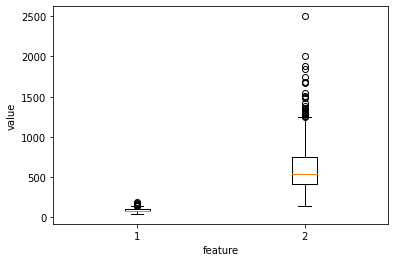

In [48]:
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [78]:
lis_i = [1,2,3,4,5,5]
for x in zip(lis_i):
  print(x)

(1,)
(2,)
(3,)
(4,)
(5,)
(5,)


### 2. 가중치를 기록할 변수와 학습률 파라미터 추가하기  

- 클래스에 인스턴스 변수를 추가하여 에포크마다 가중치의 값을 저장하여 가중치의 변화를 관찰할 때 사용해보자. (25 line)

- 학습률이라는 개념도 도입해보자. 

- 먼저 init()메서드에서 인스턴스 변수 w_history를 만들고 학습률 파라미터 learning_rate를 추가하자.  
    - learnig_rate: 하이퍼파라미터이며 변수 이름 그대로 학습률을 의미하는데, 이 값으로 가중치의 업데이트 양을 조절할 수 있다. 
 

### 3. 가중치 기록하고 업데이트 양 조절하기
- fit()메서드에 가중치가 바뀔 때마다 w_history 리스트에 가중치를 기록하겠다. 
  - 가중치를 큰 폭으로 업데이트하여 손실 함수가 최소가 될 수 있는 지점인 전역 최소값을 지나쳐 버리게 되면 최적의 해를 구할 수 없으므로, 전역 최솟값을 놓치지 않도록 가중치의 업데이트 양을 조절할 필요가 있다.(35 line)


In [49]:
class SingleLayer:
  def __init__(self, learning_rate = 0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.w_history = []
    self.lr = learning_rate

  def forpass(self,x):
    z = np.sum(x * self.w) + self.b
    return z

  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self,z):
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs = 100):
    self.w = np.ones(x.shape[1]) # 가중치를 초기화합니다
    self.b = 0                   # 절편을 초기화합니다
    self.w_history.append(self.w.copy()) #가중치를 기록합니다
    np.random.seed(42)           # 무작위로 시드를 지정합니다
    for i in range(epochs):      # epoches만큼 반복합니다
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다
      for i in indexes:            # 모든 샘플에 대해 반복합니다
        z = self.forpass(x[i])     # 정방향 계산
        a = self.activation(z)     # 활성화 함수 적용
        err = -(y[i] - a)          # 오차 계산
        w_grad, b_grad = self.backprop(x[i], err)  # 역방향 계산
        self.w -= self.lr * w_grad # 가중치 업데이트(학습률 적용)
        self.b -= b_grad           # 절편 업데이트
        # 가중치를 기록합니다
        self.w_history.append(self.w.copy( ))
        a = np.clip(a, 1e-10, 1-1e-10) # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a)) 
      self.losses.append(loss/len(y))  # 에포크마다 평균 손실을 저장합니다

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x] # 선형 함수 적용
    return np.array(z) > 0               # 계단 함수 적용

  def score(self, x, y):
    return np.mean(self.predict(x) == y)

4. 모델 훈련하고 평가하기  
: 이제 스케일을 조정하지 않은 훈련 세트를 사용하여 모델을 훈련하고 모델의 성능 점수를 확인해보자.

In [50]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp


0.9120879120879121

5. w_history에는 100번의 에포크 동안 변경된 가중치가 모두 기록되어 있다. 

- 이때 세 번째, 네 번째 요소 (w[2],w[3])는 각각 mean perimeter, mean area특성에 대한 가중치임
  - 이 요소로 그래프를 그려보자. 또 최종으로 결정된 가중치는 점으로 표시해보자  
  
그래프를 보면 mean perimeter에 비해 mean area의 스케일이 크므로 w3 값이 학습 과정에서 큰 폭으로 흔들리며 변화하고 있다. 이 그래프의 현상을 'w3에 대한 그레디언트가 크기 때문에 w3축을 따라 가중치가 크게 요동치고 있다'라고 말한다. 즉 가중치의 최적값에 도달하는 동안 w3의 값이 크게 요동치므로 모델이 불안정하게 수렴한다는 것을 알 수 있다. 이런 현상을 어떻게 줄일 수 있을까? 바로 스케일을 조정하면 된다.

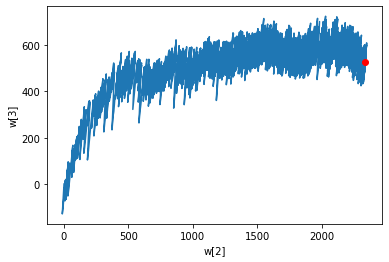

In [51]:
w2 = []
w3 = []
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

## 스케일을 조정해 모델을 훈련합니다
### 1. 넘파이로 표준화 구현하기  

- numpy의 mean() : 평균
- numpy의 std() : 표준편차

In [52]:
train_mean = np.mean(x_train, axis = 0)
train_std = np.std(x_train, axis = 0)
x_train_scaled = (x_train - train_mean) / train_std

### 2. 모델 훈련하기  
- 이제 스케일을 조정한 데이터 세트로 단일층 신경망을 다시 훈련시키고 가중치를 그래프로 그려보자  
  - w2,w3의 변화 비율이 비슷하기 때문에 대각선 방향으로 가중치가 이동됨
  - 두 특성의 스케일을 비슷하게 맞추었으므로 최적값에 빠르게 근접하고 있음 

**이처럼 경사 하강법에는 서로 다른 특성의 스케일을 맞추는 것이 아주 중요하다. 이제 검증 세트를 통해 이 모델을 평가해보자**


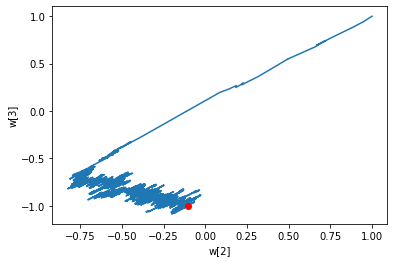

In [53]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1],w3[-1],'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

3. 모델 성능 평가하기

In [54]:
layer2.score(x_val, y_val)

0.37362637362637363

### 4. 성능이 매우 좋지 않은 이유
: 훈련 세트와 검증 세트의 스케일이 비슷할 것이라고 이 모델이 기대하는 반면에 검증 세트의 스케일을 바꾸지 않았기 때문이다. 

**검증 세트로 표준화 전처리를 적용해 보자.**

In [55]:
val_mean = np.mean(x_val, axis = 0)
val_std = np.std(x_val, axis = 0)
x_val_scaled = (x_val - val_mean) / val_std
layer2.score(x_val_scaled, y_val)

0.967032967032967

## 스케일을 조정한 다음에 실수하기 쉬운 함정을 알아봅니다

- 함정이란'훈련 세트와 검증 세트가 다른 비율로 스케일이 조정된 경우'를 말함

- 이해를 돕기 위해 원본 훈련 세트와 검증 세트, 전처리된 훈련 세트와 검증 세트에서 데이터를 50개씩 뽑아 산점도를 그린 다음 산점도를 비교해 보며 이 함정에 대해 설명해보겠다.

### 1. 원본 훈련 세트와 검증 세트로 산점도 그리기  
: 파란 점이 훈련 세트, 빨간 점이 검증 세트이다.

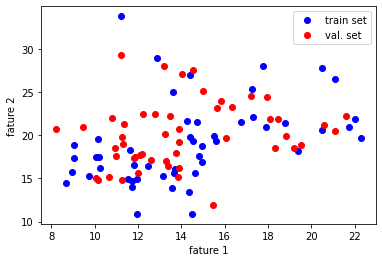

In [56]:
plt.plot(x_train[:50, 0], x_train[:50, 1], 'bo')
plt.plot(x_val[:50,0],x_val[:50,1],'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

### 2. 전처리한 훈련 세트와 검증 세트로 산점도 그리기  

- 위의 선점도와 아래의 선점도를 비교해보면 미세하지만 훈련 세트와 검증 세트가 각각 다른 비율로 변환되었음을 알 수 있다. 
- 즉, 원본 훈련 세트와 검증 세트의 점과 점 사이의 거리가 변환된 이후에 그대로 유지되지 않았다. 
- 데이터를 제대로 전처리했다면 훈련 세트와 검증 세트의 거리가 그대로 유지되어야 한다.
- 점과 점 사이의 거리가 달라진 이유는 훈련 세트와 검증 세트를 각각 다른 비율로 전처리 했기 때문이다.

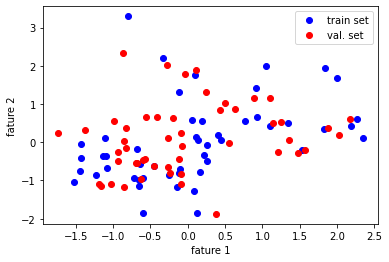

In [57]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50,0],x_val_scaled[:50,1],'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

### 3. 올바르게 검증 세트 전처리하기
- 검증 세트의 스케일이 훈련 세트의 스케일과 다른 비율로 조정되면 모델에 적용된 알고리즘들이 검증 세트의 샘플 데이터를 잘못 인식하기 때문에 검증 세트를 훈련 세트와 같은 비율로 전처리 해야 한다. 

**이는 훈련 세트의 평균, 표준 편차를 사용하여 검증 세트를 변환하면 된다.**

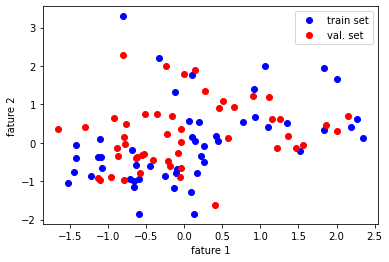

In [58]:
x_val_scaled = (x_val - train_mean) / train_std
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], 'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val. set'])
plt.show()

### 4. 모델 평가하기
- 해당 예제에서는 유방암 데이터 세트가 크지 않기 때문에 검증 세트를 전처리하기 전과 후의 성능이 동일
- 만약 검증 세트가 킅 경우에는 성능에 차이가 날 것

In [59]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

# 05-2. 과대적합과 과소적합을 알아봅니다
## 적절한 편향-분산 트레이오프를 선택합니다
: 경사 하강법의 에포크 횟수에 대한 모델의 손실을 그래프로 그려 '적절한 편향-분산 트레이드오프'를 선택해보자. 
### 1. 검증 손실을 기록하기 위한 변수 추가하기 ( 6 Line)  
: 검증세트에 대한 손실을 기록한 다음 기록한 값으로 그래프를 그려보자 

### 2. fit()메서드에 검증 세트를 전달받을 수 있도록 x_val, y_val 매개변수를 추가하자.  (34 Line)

### 3. 검증 손실 계산하기 : update_val_loss() (24 Line)
- 해당 계산은 fit()메서드에서 훈련 세트의 손실을 계산하는 방식과 동일


In [60]:
class SingleLayer:
  def __init__(self, learning_rate = 0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = [] #검증 손실 기록 변수 추가
    self.w_history = []
    self.lr = learning_rate

  def forpass(self,x):
    z = np.sum(x * self.w) + self.b
    return z

  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self,z):
    a = 1 / (1 + np.exp(-z))
    return a

  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return 
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])    # 정방향 계산
      a = self.activation(z)        # 활성화 함수 적용
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
    self.val_losses.append(val_loss/len(y_val))

  def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
    self.w = np.ones(x.shape[1]) # 가중치를 초기화합니다
    self.b = 0                   # 절편을 초기화합니다
    self.w_history.append(self.w.copy()) #가중치를 기록합니다
    np.random.seed(42)           # 무작위로 시드를 지정합니다
    for i in range(epochs):      # epoches만큼 반복합니다
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다
      for i in indexes:            # 모든 샘플에 대해 반복합니다
        z = self.forpass(x[i])     # 정방향 계산
        a = self.activation(z)     # 활성화 함수 적용
        err = -(y[i] - a)          # 오차 계산
        w_grad, b_grad = self.backprop(x[i], err)  # 역방향 계산
        self.w -= self.lr * w_grad # 가중치 업데이트(학습률 적용)
        self.b -= b_grad           # 절편 업데이트
        # 가중치를 기록합니다
        self.w_history.append(self.w.copy( ))
        a = np.clip(a, 1e-10, 1-1e-10)  # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a)) 
      self.losses.append(loss/len(y))   # 에포크마다 평균 손실을 저장합니다
      self.update_val_loss(x_val,y_val) # 검증 세트에 대한 손실을 계산한다

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x] # 선형 함수 적용
    return np.array(z) > 0               # 계단 함수 적용

  def score(self, x, y):
    return np.mean(self.predict(x) == y)

### 4. 모델 훈련하기


In [61]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)

### 5. 손실값으로 그래프 그려 에포크 횟수 지정하기  

- 검증손실이 대략 20번째 에포크 이후에 훈련 세트보다 높아지는 것을 알 수 있다
- 에포크가 진행됨에 따라 가중치는 훈련 세트에 잘 맞게 되지만 검증 세트에는 잘 맞지 않게되는 것이다. 

**따라서 이 모델은 20번의 에포크 이후에는 훈련할 필요가 없다는 것을 도출해낼 수 있다.**

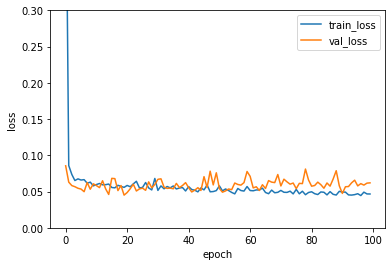

In [62]:
plt.ylim(0,0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

### 6. 훈련 조기 종료하기  
: 이렇게 훈련을 일찍 멈추는 기법을 조기 종료라고 부른다. 20번의 에포크까지 모델을 훈련한 다음 검증 세트의 성능을 확인해보자

In [63]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs = 20)
layer4.score(x_val_scaled, y_val)

0.978021978021978

In [64]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs = 100)
layer4.score(x_val_scaled, y_val)

0.967032967032967

## 로지스틱 회귀에 규제를 적용합니다
: SingleLayer 클래스에 L1,L2 규제를 적용해보자

1. 그레디언트 업데이트 수식에 패널티 항 반영하기  
: 각 규제의 기본값은 0이고 이때는 규제를 적용하지 않는다

2. fit()메서드에서 역방향 계산 수행 시 그레디언트에 패널티 항의 미분값을 더하자. 이 때 L1,L2 규제를 따로 적용하지 않고 하나의 식으로 작성한다. 즉, 두 규제를 동시에 수행할 수도 있다.

3. 로지스틱 손실 함수 계산에 패널티 항 추가하기 : reg_loss(self)

In [65]:
class SingleLayer:
  def __init__(self, learning_rate = 0.1, l1 = 0, l2 = 0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = [] 
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1 # L1 규체 추가
    self.l2 = l2 # L2 규제 추가

  def forpass(self,x):
    z = np.sum(x * self.w) + self.b
    return z

  def backprop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self,z):
    a = 1 / (1 + np.exp(-z))
    return a

  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return 
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])    # 정방향 계산
      a = self.activation(z)        # 활성화 함수 적용
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
    self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2/2 * np.sum(self.w**2)

  def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
    self.w = np.ones(x.shape[1]) # 가중치를 초기화합니다
    self.b = 0                   # 절편을 초기화합니다
    self.w_history.append(self.w.copy()) #가중치를 기록합니다
    np.random.seed(42)           # 무작위로 시드를 지정합니다
    for i in range(epochs):      # epoches만큼 반복합니다
      loss = 0
      indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다
      for i in indexes:            # 모든 샘플에 대해 반복합니다
        z = self.forpass(x[i])     # 정방향 계산
        a = self.activation(z)     # 활성화 함수 적용
        err = -(y[i] - a)          # 오차 계산
        w_grad, b_grad = self.backprop(x[i], err)  # 역방향 계산
        # 그레디언트에서 패널티 항의 미분값을 더합니다
        w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
        self.w -= self.lr * w_grad # 가중치 업데이트(학습률 적용)
        self.b -= b_grad           # 절편 업데이트
        # 가중치를 기록합니다
        self.w_history.append(self.w.copy( ))
        a = np.clip(a, 1e-10, 1-1e-10)  # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a)) 
      self.losses.append(loss/len(y) + self.reg_loss())   # 에포크마다 평균 손실을 저장합니다
      self.update_val_loss(x_val,y_val) # 검증 세트에 대한 손실을 계산한다

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x] # 선형 함수 적용
    return np.array(z) > 0               # 계단 함수 적용

  def score(self, x, y):
    return np.mean(self.predict(x) == y)

5. cancer 데이터 세트에 L1규제 적용하기  
: 왼쪽은 학습 곡선 그래프, 오른쪽은 가중치에 대한 그래프이다  
학습 곡선 그래프를 보면 규제가 더 커질수록 훈련 세트의 손실과 검증 세트의 손실이 모두 높아진다. 즉 과소적합 현상이 나타난다. 가중치 그래프를 보면 규제 강도 l1값이 커질수록 가중치의 값이 0에 가까워지는 것을 볼 수 있다. 

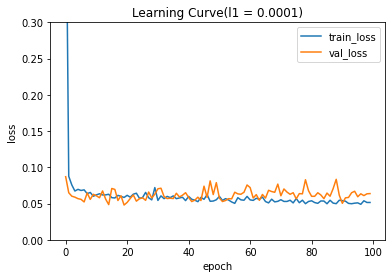

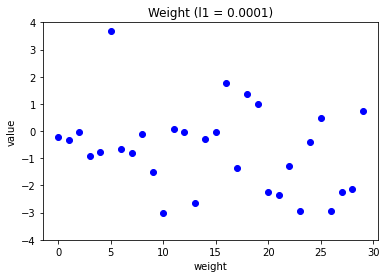

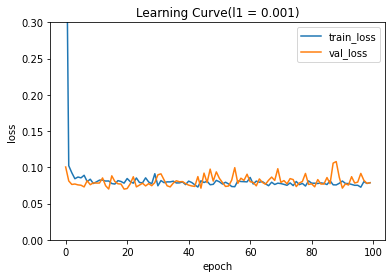

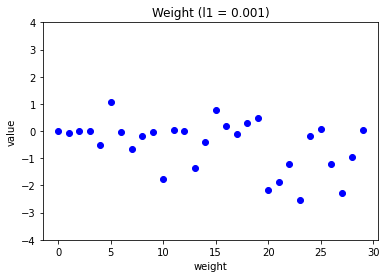

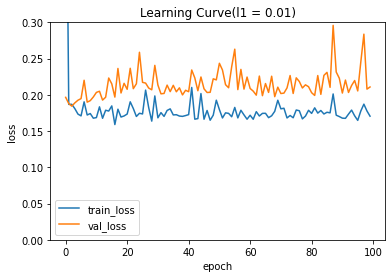

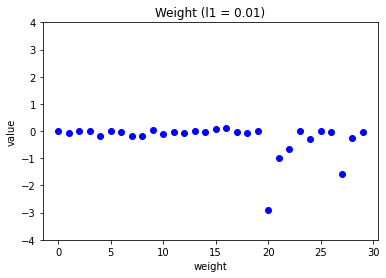

In [66]:
l1_list = [0.0001,0.001,0.01]

for l1 in l1_list:
  lyr = SingleLayer(l1 = l1)
  lyr.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)

  
  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve(l1 = {})'.format(l1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0,0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l1 = {})'.format(l1))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4,4)
  plt.show()


: 그래프를 보면 적절한 l1 하이퍼파라미터 값은 0.001정도인 것을 추측할 수 있다. 이 값을 사용하여 모델의 성능을 확인해보자  
결과를 보니 규제를 적용하지 않고 검증세트로 성능을 평가했을 때와 값이 동일함을 알 수 있다. 이는 데이터 세트가 작기 때문에 규제 효과가 크게 나타나지 않았기 때문이다

In [67]:
layer5 = SingleLayer(l1 = 0.001)
layer5.fit(x_train_scaled, y_train, epochs = 20)
layer5.score(x_val_scaled, y_val)

0.978021978021978

6. cancer 데이터 세트에 L2 규제 적용하기  
: 두 그래프를 보면 L2,L1 규제 모두 비슷한 양상을 보이나 마지막 학습 곡선 그래프를 보면 L2 규제는 규제 강도가 강해져도 L1규제 만큼 과소적합이 심해지지 않음을 확인할 수 있다. 가중치 그래프를 보아도 가중치가 0에 너무 가깝게 줄어들지 않는다는 것을 알 수 있다.

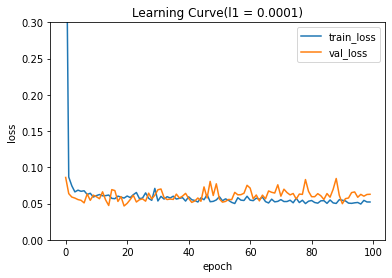

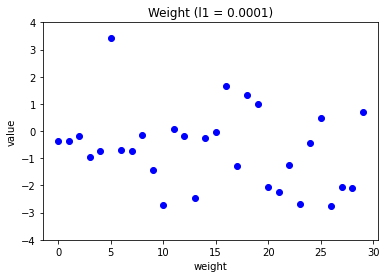

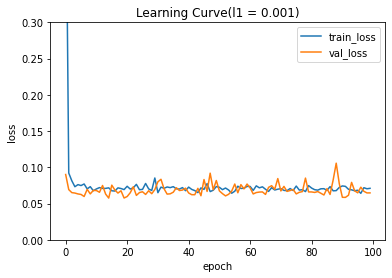

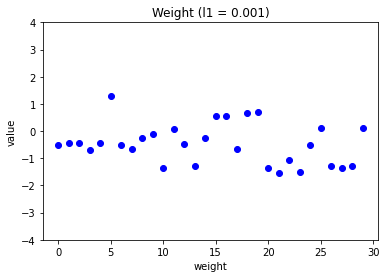

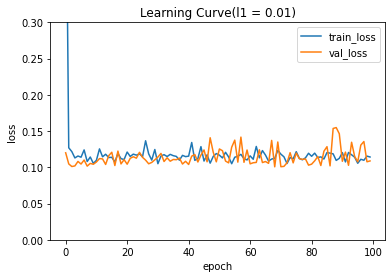

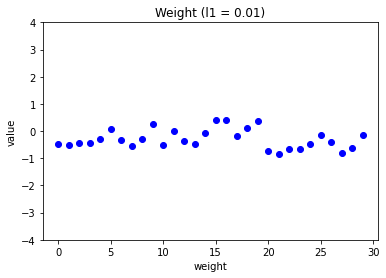

In [68]:
l2_list = [0.0001,0.001,0.01]

for l2 in l2_list:
  lyr = SingleLayer(l2 = l2)
  lyr.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)

  
  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve(l1 = {})'.format(l2))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0,0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l1 = {})'.format(l2))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4,4)
  plt.show()


: L2 규제를 적용한 모델 역시 50번의 에포크 횟수만큼 훈련하고 성능을 평가해보자  
결과를 보니 L1규제와 같다. 이는 cancer 데이터 세트의 샘플 개수가 아주 적어서 두 규제를 적용한 모델에서 성능 차이가 크지 않기 때문이다.

In [69]:
layer6 = SingleLayer(l2 = 0.001)
layer6.fit(x_train_scaled, y_train, epochs = 50)
layer6.score(x_val_scaled, y_val)

0.967032967032967

: 아래에서 확인할 수 있듯이 두 모델은 모두 검증 샘플에 대하여 옳게 예측한 샘플의 개수가 91개 중 89개로 동일하다.   
하지만 L1규제를 사용했을 때보다 에포크가 크게 늘어났다. 이는 가중치를 강하게 제한했기 때문에 검증 세트의 손실값을 일정한 수준으로 유지하면서 알고리즘이 전역 최솟값을 찾는 과정을 오래 반복할 수 있었기 때문이다.

In [70]:
np.sum(layer6.predict(x_val_scaled) == y_val)

88

7. SGDClassifier에서 규제 사용하기

In [71]:
sgd = SGDClassifier(loss = 'log', penalty = 'l2', alpha = 0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

# 05-4. 교차 검증을 알아보고 사이킷런으로 수행해 봅니다
## k-폴드 교차 검증을 구현합니다
1. 훈련 세트 사용하기  
: 기존의 방식과 다르게 k-폴드 교차 검증은 검증 세트가 훈련 세트에 포함되므로 전체 데이터 세트를 다시 훈련 세트와 테스트 세트로 1번만 나눈 x_train_all, y_train_all을 훈련과 검증에 사용하자.   
또 각 폴드의 검증 점수를 저장하기 위한 validation_scores 리스트 정의

In [72]:
validation_scores = []

2. k-폴드 교차 검증 구현하기  
: start, end는 각각 검증 폴드 샘플의 시작과 끝 인덱스  
- 중요: 훈련 데이터의 표준화 전처리를 폴드를 나눈 후에 수행함!

In [73]:
k = 10
bins = len(x_train_all) // k
for i in range(k):
  start = i * bins
  end = (i+1) * bins
  val_fold = x_train_all[start:end]
  val_target = y_train_all[start:end]

  train_index = list(range(0,start))+list(range(end,len(x_train)))
  train_fold = x_train_all[train_index]
  train_target = y_train_all[train_index]

  train_mean = np.mean(train_fold, axis = 0)
  train_std = np.std(train_fold, axis = 0)
  train_fold_scaled = (train_fold - train_mean) / train_std
  val_fold_scaled = (val_fold - train_mean) / train_std

  lyr = SingleLayer(l2 = 0.01)
  lyr.fit(train_fold_scaled, train_target, epochs = 50)
  score = lyr.score(val_fold_scaled, val_target)
  validation_scores.append(score)

print(np.mean(validation_scores))  

0.9711111111111113


## 사이킷런으로 교차 검증을 합니다
: 사이킷런의 model_section 모듈에는 교차 검증을 위한 cross_validate()함수가 있다.   
1. cross_validate()함수로 교차 검증 점수 계산하기  
: 매개변수 값으로 교차 검증을 하고 싶은 모델의 객체와 훈련 데이터, 타깃 데이터를 전달하고 cv매개변수에 수행할 폴드 수를 지정하면 됨

In [74]:
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss = 'log', penalty='l2', alpha=0.001, random_state=42)
scores = cross_validate(sgd, x_train_all, y_train_all, cv = 10)
print(np.mean (scores['test_score']))

0.850096618357488


## 전처리 단계 포함해 교차검증을 수행합니다
: 앞의 방식과 다르게 훈련 세트 전체를 전처리 한 후에 cross_validate() 함수에 매개변수 값으로 전달하면 검증폴드가 표준화 전처리 단계에서 누설되므로 새로운 방법을 찾아야 함

### Pipeline 클래스 사용해 교차 검증 수행하기
: 사이킷런에서는 검증 폴드가 전처리 단계에서 누설되지 않도록 전처리 단계와 모델 클래스 하나로 연결해주는 클래스를 제공함

In [75]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe = make_pipeline(StandardScaler(),sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv = 10, return_train_score=True)
print(np.mean (scores['test_score']))

0.9694202898550724
